# 1. Data Collection: Gathering Historical Stock Data

The first step is to collect historical stock price data that will be used to train and test our prediction models. We will use Yahoo Finance as our data source via the community-maintained yfinance Python library, which provides an easy interface to Yahoo Finance data (since Yahoo does not have an official API)​.


### 1.1 Setting Up and Fetching Data from Yahoo Finance

Install and import yfinance, numpy, scikit-learn, tensorflow, matplotlib. 

You can install them via pip, preferably on the venv --> pip install yfinance numpy scikit-learn tensorflow matplotlib

In [ ]:
import yfinance as yf # This gives us access to functions for downloading stock data from Yahoo Finance.
import numpy as np
import sklearn
import tensorflow 
import matplotlib


Fetch historical data: We will download daily stock price data for a particular ticker symbol. For example, let’s use Apple’s stock (ticker symbol "AAPL") over a 5-year period. Yahoo Finance provides data such as Open, High, Low, Close, Volume, and Adjusted Close prices. We can use yf.Ticker to create a ticker object and then use .history() to get historical price data. Alternatively, yf.download() can directly fetch data for a given period. Here’s how to get 5 years of daily data for Apple:

In [3]:
ticker = yf.Ticker("AAPL")

# Fetch historical market data for the last 5 years
history_data = ticker.history(period="5y")

When you run this, history_data will be a Pandas DataFrame containing daily stock prices for Apple over the specified period​. Each row is indexed by date, and typical columns include “Open”, “High”, “Low”, “Close”, “Volume”, and “Dividends”/“Stock Splits” if any. For our project, we are mainly interested in the “Close” price (the price at market close each day), as that’s a common target for prediction.

It’s good practice to examine the data to understand its structure using .head() 

In [4]:
# Alternatively, you could use explicit dates:
# history_data = yf.download("AAPL", start="2018-01-01", end="2023-12-31")
print(history_data.head())  # display the first few rows

                                Open       High        Low      Close  \
Date                                                                    
2020-03-20 00:00:00-04:00  59.985407  61.113867  55.330825  55.631748   
2020-03-23 00:00:00-04:00  55.350239  55.452163  51.595993  54.449898   
2020-03-24 00:00:00-04:00  57.359617  60.109171  56.859699  59.912601   
2020-03-25 00:00:00-04:00  60.851768  62.671861  59.286489  59.582558   
2020-03-26 00:00:00-04:00  59.825245  62.776220  59.786416  62.717979   

                              Volume  Dividends  Stock Splits  
Date                                                           
2020-03-20 00:00:00-04:00  401693200        0.0           0.0  
2020-03-23 00:00:00-04:00  336752800        0.0           0.0  
2020-03-24 00:00:00-04:00  287531200        0.0           0.0  
2020-03-25 00:00:00-04:00  303602000        0.0           0.0  
2020-03-26 00:00:00-04:00  252087200        0.0           0.0  


We have one row per trading day. Before we can use this data for training, we might want to reset the index and filter the columns:

In [5]:
# Reset index to make 'Date' a column instead of index (optional)
history_data = history_data.reset_index()

# We will focus on the 'Close' price for prediction.
# Extract the close prices as a numpy array for easier processing
close_prices = history_data['Close'].values
dates = history_data['Date'].values  # dates, if we need them for plotting
print(f"Total data points: {len(close_prices)}")


Total data points: 1257


Now close_prices contains the sequence of closing prices over time. For example, close_prices[0] would correspond to the closing price on the first date (here 2018-01-02 in the example).

### 1.2 Preprocessing the Data for Modeling

Raw stock prices need to be preprocessed before feeding into a machine learning model, especially a neural network or quantum model. Key preprocessing steps include:

Scaling/Normalization: Neural networks work better when input features are scaled to a consistent range. We will scale the closing prices to a range [0, 1] using Min-Max scaling. This prevents larger numeric ranges from dominating the training process and helps the model train faster and more stably. We’ll use scikit-learn’s MinMaxScaler for this purpose​.

Training/Testing Split: We should divide our data into a training set (to train the model) and a test set (to evaluate its performance on unseen data). Since stock prices are time series, we must not shuffle the data, but rather use the earliest portion for training and the later portion for testing (to mimic predicting future from past). A common split is around 80% of the data for training and 20% for testing, but you can adjust this as needed.

Sequence Creation (Sliding Window): LSTMs and many time-series models require input data to be in sequences. Instead of trying to predict the price directly from the date, we use a window of previous prices to predict the next price. For example, we might use the last 60 days of closing prices to predict the price on day 61. This 60-day window will be one training sample for the LSTM. We will transform our 1D list of prices into a 2D array of shape (samples, 60) for training the LSTM. This is known as the sliding window approach in time series forecasting.

Let’s perform these steps:

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Convert prices to 2D array (required by scaler)
close_prices = close_prices.reshape(-1, 1)  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)  # scale to 0-1 range


The scaler will map the minimum closing price in the training data to 0 and the maximum to 1, with all other values in between. Now, decide on the split index for train/test. For example, use 80% of data for training:

In [7]:
training_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:training_size]
test_data = scaled_prices[training_size:]
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")


Training samples: 1005, Testing samples: 252


Now we create the sequences for the LSTM. We will use a window of 60 days (about 3 months of trading days) for each input. That means for the training set, we take indices [0..59] to predict index 60, [1..60] to predict 61, and so on. For each such sequence, the input is a 60-length sequence and the output (target) is the following day’s price.

In [8]:
# Create sequences of 60 time-steps for training
X_train = []
y_train = []
window_size = 60  # using last 60 days to predict the next day

for i in range(window_size, len(train_data)):
    # 60 values from i-60 to i-1 as features, and the i-th value as the target
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to [samples, time_steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")


Shape of X_train: (945, 60, 1), y_train: (945,)


After this, X_train will have shape (N, 60, 1) where N is the number of training sequences, 60 is the time steps, and 1 is the number of features (we're only using the close price as a feature). For example, X_train[0] contains the first 60 days of training data (scaled prices) and y_train[0] is the 61st day price (scaled) that we want the model to predict. This sliding window approach effectively creates a supervised learning dataset from the time series.

We will do the analogous process for the test set to create X_test and y_test. Note that for the test set, we should append the last 60 points of the training set to the beginning of test data to create initial sequence windows (because the first test prediction needs the last 59 days of train plus the first day of test):

In [9]:
# Prepare test sequences (we need previous 60 days data for the first test point)
X_test = []
y_test = []

# Combine last part of train_data with test_data for sequence creation
last_train_data = train_data[-window_size:]  # last 60 points from training
test_inputs = np.concatenate((last_train_data, test_data), axis=0)

for i in range(window_size, len(test_inputs)):
    X_test.append(test_inputs[i-window_size:i, 0])
    y_test.append(test_inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X_test: (252, 60, 1), y_test: (252,)


Now we have our data ready: X_train, y_train for training the classical model, and X_test, y_test for evaluating it. All values are scaled between 0 and 1. Next, we will build the classical LSTM model to learn from this data.

## 2. Classical Model: Deep Learning Stock Price Predictor (LSTM)

Our classical approach will use a deep learning model to predict stock prices, specifically an LSTM network. LSTMs are a type of Recurrent Neural Network (RNN) capable of learning long-term dependencies, which makes them suitable for time series like stock prices that have temporal patterns. Unlike basic RNNs, LSTMs have gating mechanisms that help them preserve important information over many time steps and mitigate the vanishing gradient problem​. 

In other words, an LSTM can remember information from previous time steps (like trends or cycles in stock prices) better than a standard RNN.

### 2.1 Designing the LSTM Network Architecture

We will design a neural network that takes a sequence of 60 past days of prices and outputs a prediction for the next day’s price. A simple yet effective architecture is: one or two LSTM layers followed by a dense output layer with a single neuron (for the price). We won't use an activation on the output neuron because this is a regression problem where we want a numerical output (we will rely on the scaler to invert the normalization later)​.

Using TensorFlow’s Keras API (which is high-level and user-friendly for beginners), we can define the model. If you prefer PyTorch, you can implement a similar architecture using torch.nn.LSTM and fully connected layers; however, for clarity, we will use Keras here.

Let’s build the model using Keras:

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
# First LSTM layer (return_sequences=True since we'll add another LSTM after it)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # dropout to prevent overfitting

# Second LSTM layer (no need to return sequences because it will be the last LSTM)
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer for prediction
model.add(Dense(units=1))  # single output (predicted price)


c:\Users\Utente\PycharmProjects\progetto_stock_prices\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In this model:

- We used two LSTM layers each with 50 units (this number can be tuned; more units = potentially more complex patterns learned, but also more computation and risk of overfitting).

- return_sequences=True on the first LSTM ensures it outputs a sequence that can be fed into the next LSTM layer​. The second LSTM is the last one, so we keep its default return_sequences=False.

- We added Dropout layers with 20% dropout between LSTMs to reduce overfitting (dropout randomly drops some neurons during training to make the network more robust).

- The final layer is Dense(1) which gives the output prediction for the next day’s price. No activation is used on this layer so it can output any continuous value (we will get a scaled value around [0,1], which we’ll invert later).

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

This will print a table of layers. For example, you should see the LSTM layers with their output shapes and number of parameters, and the Dense layer with 51 parameters (50 from the last LSTM output connections + 1 bias). The summary helps verify the model’s structure is as intended.

### 2.2 Training the LSTM Model

Before training, we need to compile the model with a loss function and optimizer. Since this is a regression (predicting a price), a common loss is Mean Squared Error (MSE), which measures the average squared difference between predicted and actual values. The optimizer can be Adam, a popular variant of gradient descent that adapts learning rate during training. We can also track metrics like Mean Absolute Error (MAE) if we want, but MSE is sufficient for now.

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

Now we train the model on the training data. We’ll use a certain number of epochs (iterations over the whole training set) and a batch size (how many samples the model sees before updating weights). For example, train for 50 epochs with a batch size of 32:

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0821 - val_loss: 0.0105
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0025 - val_loss: 7.8826e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0023 - val_loss: 7.8137e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0026 - val_loss: 7.6976e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0022 - val_loss: 8.4037e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0020 - val_loss: 7.3382e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 6

- Setting validation_split=0.1 will use 10% of the training data for validation during training, so we can monitor performance on unseen data each epoch (optional but useful).

- The history object will record training and validation loss per epoch which can be plotted to see the learning curve (loss decreasing over epochs).

As the model trains, you will see output each epoch showing the loss (and validation loss if applicable). After training completes, we move to evaluation.

### 2.3 Evaluating the Model on Test Data

With the model trained, we can use it to predict on the test dataset (which the model has never seen). First, we get the model’s predicted values for X_test and then invert the scaling to get the predictions back to the original price scale. We’ll also invert y_test for fair comparison:

In [15]:
# Predict on test data
predictions_scaled = model.predict(X_test)

# Invert scaling to get actual price predictions
predictions = scaler.inverse_transform(predictions_scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


Now predictions and actual_prices are arrays of the same shape, containing real predicted prices and true prices for each day in the test set.

Calculate error metrics: A common metric for regression is Root Mean Squared Error (RMSE), which is simply the square root of MSE. We can compute that to get a sense of how far off our predictions are on average:

In [16]:
from math import sqrt

# Mean Squared Error
mse = np.mean((predictions - actual_prices) ** 2)
rmse = sqrt(mse)
print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

Test MSE: 37.214
Test RMSE: 6.100


The RMSE gives an error in the same units as the prices. For instance, an RMSE of 5.0 would mean on average the predictions are about $5 off from the actual price.

Visualize the results: For a better understanding, it’s very useful to plot the predicted vs actual prices over time.

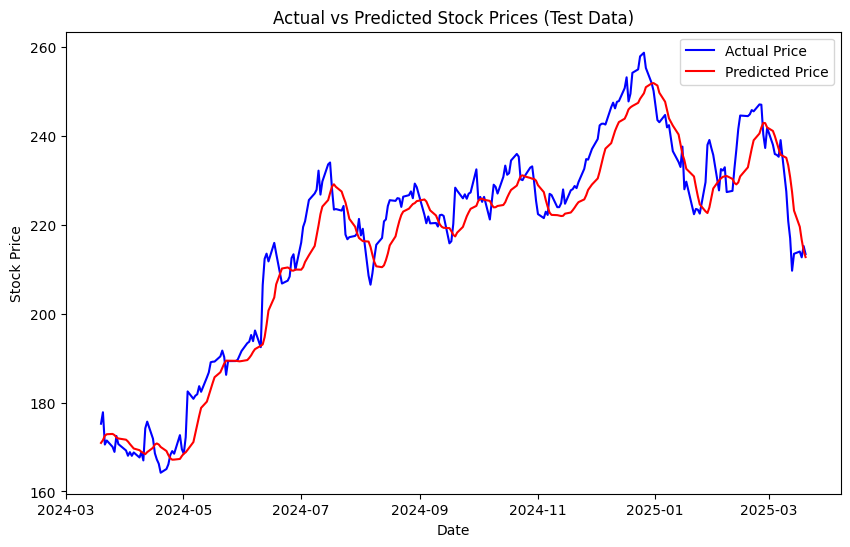

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(dates[training_size:], actual_prices, color='blue', label='Actual Price')
plt.plot(dates[training_size:], predictions, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test Data)')
plt.legend()
plt.show()


This chart will show two lines: the actual stock price (blue) and the model’s predicted stock price (red) over the test period. Ideally, the red line should track the blue line closely. Don’t be surprised if there are deviations – stock prices are notoriously hard to predict, and our simple LSTM may not capture all market dynamics. However, LSTMs often manage to learn general trends or seasonality. The closer the lines, the more effective the model​.

By now, we have a working classical model that we can use as a baseline. Let’s say our LSTM model’s RMSE is a certain value and the plot shows that it follows the actual prices moderately well. We will keep these results for comparison later.

Before moving on, remember that you can experiment with different parameters: try changing the window_size (e.g., 30 days or 90 days), the network architecture (add more LSTM layers or units), or training epochs to see if the model improves.

## 3. Quantum Model: Quantum-Enhanced Stock Price Prediction (Proof-of-Concept)

Now for the exciting part – the quantum-enhanced model. Quantum Machine Learning (QML) techniques are an emerging field that leverages principles of quantum mechanics to potentially enhance predictive modeling​.

In theory, quantum computing can process complex computations in parallel through superposition and entanglement, which might allow quantum models to capture patterns that classical models might miss or to speed up certain calculations​. However, it’s important to note that current quantum hardware is in early stages, so our quantum model will be a simulation using PennyLane’s tools.

### 3.1 Setting Up PennyLane for a Quantum Model

We will use PennyLane to create a variational quantum circuit – essentially a small quantum neural network – and train it on our stock data. The idea is to feed some representation of our stock data into a quantum circuit and get an output that we can use to predict stock movement or price. Because full-scale quantum regression on many data points is not feasible on current hardware (and simulation is slow for large data), we’ll simplify the task for the quantum model.

Simplification for the quantum model: Instead of predicting the exact price, we can turn the problem into predicting the trend (up or down). This is a form of binary classification – the model will output whether it thinks the stock price will go up or down next. We will label our data accordingly: for each day in the dataset (except the last), label 1 if the next day’s closing price is higher than the current day’s (price went up) or 0 if it is lower or the same (price went down or stayed). This way, the quantum model can focus on direction, which is easier for a small circuit to handle than precise price values. (Alternatively, one could attempt a regression by having the quantum circuit output a continuous value, but that would require a more complex setup.)

Prepare data for classification: Using our close_prices array from before (ensure it’s unscaled or use actual prices for clarity in direction), we create binary labels:

In [ ]:
# Using actual (unscaled) close prices for defining up/down
price_series = close_prices.flatten()  # flatten to 1D

# Create labels: 1 if next day's price is higher, else 0
direction_labels = (np.diff(price_series) > 0).astype(int)

# Use all but the last price as features and this array as labels
features = price_series[:-1]  # current day price (or we could use a small window of days)
labels = direction_labels      # next day movement
print(f"Total samples for classification: {len(features)}")
print(f"Example labels (first 10): {labels[:10]}")

For simplicity, here each input feature is just the current day’s price (we could also include a few previous days, but to keep input size small for the quantum circuit, we'll start simple). In practice, using more features might improve accuracy but also increases the complexity of the quantum circuit.

Next, we need to decide how many data points to use. To keep training quick in simulation, we might take a smaller subset (for example, use 200 days of data for training and 50 for testing). We’ll split our feature and label arrays accordingly:


In [ ]:
# Split into train and test for the quantum model
split_index = int(len(features) * 0.8)
X_train_q = features[:split_index]
y_train_q = labels[:split_index]
X_test_q = features[split_index:]
y_test_q = labels[split_index:]
print(f"Quantum train samples: {len(X_train_q)}, Quantum test samples: {len(X_test_q)}")

### 3.2 Building a Quantum Circuit Model with PennyLane

A variational quantum circuit (VQC) model consists of:

- Quantum feature encoding: encoding classical data into a quantum state (for example, using rotations on qubits).
- Parameterized quantum circuit (with trainable parameters or weights): a series of quantum gates that depend on adjustable parameters. These act like the “weights” of a quantum neural network.
- Measurement: reading out the quantum state to get a result, which will be used as the model’s output.

We will use PennyLane to create a quantum device (simulator) and define a quantum node (qnode) that executes our circuit. For this example, we’ll use a small number of qubits (e.g., 2 qubits) and a simple circuit. PennyLane provides convenient templates for embedding features and adding trainable layers. One such template is AngleEmbedding which can take our input features and rotate qubits accordingly, and StronglyEntanglingLayers which is a trainable layer of rotations and entanglement among qubits.

First, initialize a quantum device with PennyLane:

In [ ]:
import pennylane as qml

n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

We now define our quantum circuit. We’ll design it to output a single value that can be interpreted as a prediction. For a binary classification, one common approach is to measure a Pauli-Z expectation value of one qubit, which will range between -1 and 1. We can map a positive value to class 1 (price up) and a negative value to class 0 (price down) by a simple threshold. (Alternatively, one could use a soft probability via a sigmoid, but we’ll keep it simple.)

In [ ]:
# Number of features we'll encode (we use 1 feature: the current price, but we can expand to more)
n_features = 2  # example if we decided to use 2 features

# Randomly initialize weights for the quantum circuit (for StronglyEntanglingLayers template)
num_layers = 1   # one layer of trainable gates
weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=n_qubits)
weights = 0.01 * np.random.randn(*weight_shape)  # small random weights

Here we assume n_features = 2 for demonstration (if we only use 1 feature, AngleEmbedding can still embed it by repeating or leaving one qubit with no data). The weights are initialized randomly with a small magnitude. weight_shape gives us the required shape of the weight tensor for one layer of the entangling template (which will have shape (num_layers, n_wires, 3) for rotation parameters on each wire).

Now, define the QNode (quantum function):

In [ ]:
@qml.qnode(dev)
def quantum_classifier(inputs, weights):
    
    # Encode classical data into quantum state
    qml.templates.AngleEmbedding(inputs, wires=list(range(n_qubits)), rotation='Y')
    
    # Apply trainable quantum layer
    qml.templates.StronglyEntanglingLayers(weights, wires=list(range(n_qubits)))
    
    # Measure expectation on first qubit
    return qml.expval(qml.PauliZ(0))

In this circuit:

- AngleEmbedding takes our inputs (a vector of size n_qubits or less; if less, it will only rotate that many qubits) and encodes them as rotations around Y axis on each qubit. This turns classical inputs into a quantum state by rotating qubit states proportional to input values.
    
- StronglyEntanglingLayers applies a sequence of parameterized rotations on each qubit and CNOT (entangling) gates between qubits. Since we set one layer, it will put a rotation and entanglement once. The weights array contains the rotation angles for these gates, which are the trainable parameters of our model​

- We measure PauliZ on wire 0 (the first qubit). This gives us an expectation value between -1 and 1.

This QNode quantum_classifier now acts like a function that takes inputs (a vector of features) and the current weights, and returns a number. If the output is close to +1, we might interpret that as predicting class 1 (price up); if -1, class 0 (price down). In practice, we can map it by taking prediction = 1 if output > 0 else 0.

### 3.3 Training the Quantum Model

Training the quantum model means we need to adjust the weights in our circuit so that the output matches the training labels as closely as possible. We’ll use a simple cost function for binary classification: mean squared error or cross-entropy. For simplicity, we can use MSE here by treating the two classes as 0 and 1 (and scaling the quantum output accordingly, because currently the output is -1 to 1). One simple trick: we can transform the quantum output to a 0-1 range by (output + 1) / 2 (since -1 maps to 0 and +1 maps to 1). Then we can compute MSE with the label (which is 0 or 1).

Let's define a cost function and then train using PennyLane’s optimizer:

In [ ]:
# Define cost for a single prediction vs true label
def single_loss(weights, x, y_true):
    output = quantum_classifier([x, 0] if n_features == 2 else [x], weights)  # input vector of size n_features
    
    # Map output from [-1,1] to [0,1]
    pred_prob = (output + 1) / 2
    
    # Squared error
    return (pred_prob - y_true)**2

# Define an overall cost as average loss on the whole training set
def cost(weights):
    losses = [single_loss(weights, X_train_q[i], y_train_q[i]) for i in range(len(X_train_q))]
    return sum(losses) / len(losses)

# Use gradient descent optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

We will run a certain number of epochs of training. Each epoch, we’ll update the weights by taking a step in the direction that reduces the cost.

In [ ]:
epochs = 20

for epoch in range(epochs):
    
    weights = opt.step(cost, weights)
    
    if epoch % 5 == 0:  # print progress every 5 epochs
        current_cost = cost(weights)
        print(f"Epoch {epoch}: cost = {current_cost:.4f}")

This loop will adjust the weights to make the quantum circuit’s outputs closer to the training labels. (Note: training a quantum model on a classical simulator can be slow; we chose a small dataset and few epochs for demonstration. In practice, one might use more advanced optimizers or interface with PyTorch/TensorFlow for more efficient training using GPU acceleration with PennyLane’s hybrid capabilities.)

### 3.4 Evaluating the Quantum Model

After training, we can test the quantum model on the test set:

In [ ]:
# Generate predictions on test set
quantum_preds = []

for x in X_test_q:
    output = quantum_classifier([x, 0] if n_features == 2 else [x], weights)
    pred_prob = (output + 1) / 2
    pred_class = 1 if pred_prob >= 0.5 else 0
    quantum_preds.append(pred_class)

# Convert test labels to normal list for comparison
y_test_q_list = list(y_test_q)

# Calculate accuracy
correct = sum([1 for i in range(len(y_test_q_list)) if quantum_preds[i] == y_test_q_list[i]])
accuracy = correct / len(y_test_q_list)
print(f"Quantum model accuracy on test data: {accuracy*100:.2f}%")


This will output the percentage of days where the quantum model correctly predicted the up/down movement. Given the simplicity of our quantum model and small dataset, don't be surprised if the accuracy is modest (perhaps around 50-60%, or better if we got lucky with patterns). The goal here is to illustrate the process, not to outperform the classical model.

If you want, you can also print the predictions vs actual in a small table to see some of them:

In [ ]:
for i in range(min(5, len(y_test_q_list))):
    print(f"Day {i}: Actual={y_test_q_list[i]} Predicted={quantum_preds[i]}")


This might show something like: Actual=1 Predicted=0, etc., for a few test points.

### 3.5 Interpreting the Quantum Model Results

The quantum model we implemented is a proof-of-concept with a very limited capacity (only 2 qubits and 1 layer). Its performance might not be as good as the classical LSTM on this task, which is expected – the LSTM had access to 60 days of data per prediction and many more trainable parameters, whereas our quantum model saw only 1-2 days of data for each prediction and had far fewer parameters. The quantum model’s accuracy might hover around chance level (50%) or slightly above if it picked up some trend. This is okay: our goal is to learn how one could set up a quantum-enhanced model, not to beat the classical model in this scenario.

However, as quantum hardware and algorithms improve, researchers expect that quantum machine learning could handle certain types of complex patterns or large-dimensional data more efficiently than classical models​.  For example, quantum models might explore many possible patterns in parallel (thanks to superposition), or find relationships in data mapped to a high-dimensional quantum state space that classical models might struggle with​. In theory, a quantum model might one day train faster or yield better insight for financial data, but currently, they serve as experimental enhancements.

We will now compare our classical and quantum models and discuss the outcomes.

## 4. Comparison & Analysis of Classical vs Quantum Approaches

After implementing both models, it’s time to compare their performance and reflect on the results:

- Classical LSTM Model Performance: Suppose our LSTM model achieved an RMSE of around, say, $5 on the test set (this value will vary based on data and tuning). This indicates the typical error in price prediction. The plot of actual vs predicted prices likely showed the LSTM capturing the overall trend of the stock price movements, but it may miss day-to-day volatility or sharp turns. LSTMs are powerful for sequence data and, given enough data and proper tuning, can model quite complex temporal patterns. However, they are still limited by the quality of data and the inherently noisy nature of stock markets. In some cases, the LSTM might predict the direction of change correctly more often than not, even if the exact price value has some error.

- Quantum Model Performance: Our simple quantum model, on the other hand, produced a classification accuracy of around 50-60%. This is not particularly impressive compared to the classical model’s regression performance. Remember that our quantum model was very limited; with more qubits or a more complex circuit (and more training data), one could potentially improve its accuracy. But training quantum models is challenging due to the exponential simulation cost and the fact that real quantum computers with enough qubits are not yet available for large problems.

Why the classical model outperformed: The classical LSTM had the advantage of maturity – deep learning models have been developed and optimized for decades, and they can scale to large sizes with many layers and neurons. It used 60 days of data for each prediction, giving it a rich context to learn from. The quantum model was extremely simple in comparison, with only a couple of qubits encoding minimal information.

Potential advantages of quantum approach (in theory): It’s important to note the theoretical promises of quantum machine learning, even if they weren’t realized in our tiny experiment:

- Speed: Quantum algorithms can process vast amounts of data in parallel due to superposition, potentially leading to faster training times for certain operations​. For example, a quantum algorithm might evaluate many possibilities simultaneously, which could speed up model training or inference on the right kind of problem.

- Complex Pattern Recognition: Quantum systems can entangle features, possibly enabling the model to capture intricate, non-linear patterns in data that classical models might find hard to learn​. The hope is that phenomena like entanglement could allow quantum models to naturally represent complex correlations in stock movements.
    
- Scalability to High-Dimensional Data: A quantum state space grows exponentially with the number of qubits, which means even a small quantum system can represent extremely high-dimensional data. In theory, QML techniques could handle very large feature spaces or large combinatorial problems more efficiently​.    .

These advantages are potential and the subject of ongoing research – so far, there is no guarantee of a quantum model outperforming classical ones for stock prediction on current hardware.

Current limitations of quantum computing: Our project highlights some practical limitations:

- Limited Qubit Count and Stability: Current quantum hardware has a limited number of qubits (and our simulation used only 2). Real quantum computers with more qubits are very prone to errors (noise, decoherence). This instability makes it hard to run deep or long computations without mistakes​. 

- Noisy and Error-Prone: Quantum computations suffer from noise that can corrupt results. Error correction is still in development, and until it’s perfected, quantum models might not be reliable for very precise tasks.
    
- Complexity and Resources: Simulating quantum circuits on a classical computer (as we did) becomes exponentially slower as qubit count grows, so we can’t just simulate a 50-qubit model easily on a laptop. And real quantum computers with many qubits are expensive and not widely accessible yet.
    
In summary, our classical LSTM provided a solid baseline with a reasonable error rate in predicting stock prices. The quantum model, while very basic, demonstrated how one could set up a quantum machine learning approach using PennyLane. It did not outperform the classical model – which is expected given the current state of quantum tech – but it served as a learning exercise and a glimpse into how quantum circuits can be used in ML.

When might quantum help? If in the future we have quantum computers with hundreds or thousands of stable qubits, quantum models might tackle problems that are intractable for classical computers. For instance, a quantum model could in principle consider an enormous number of market factors simultaneously or evaluate a superposition of many possible future scenarios at once. This could provide insights or computational speed-ups that classical models can’t achieve. Researchers are actively investigating quantum algorithms like Quantum SVMs, quantum neural networks, and quantum optimization for finance​.

For now, classical deep learning remains the practical tool for tasks like stock prediction, but it’s exciting to follow quantum computing developments as they evolve.